# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Top-ranking-universities-in-www.topuniversities.com-(ranking-2018)"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>DataFrame creation for www.topuniversities.com</a></div>
 <div class="lev1"><a href="#Task-2.-Top-ranking-universities-in-www.timeshighereducation.com-(ranking-2018)"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>Top-ranking universities in www.timeshighereducation.com (ranking 2018)</a></div>
 <div class="lev1"><a href="#Task-3.-Merger-of-the-DataFrames"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Merger of the DataFrames</a></div>
 <div class="lev1"><a href="#Task-4.-Exploratory-analysis"><span class="toc-item-num">Task 4.&nbsp;&nbsp;</span>Exploratory analysis</a></div>
 <div class="lev1"><a href="#Task-5.-Finding-the-best-univeristy"><span class="toc-item-num">Task 5.&nbsp;&nbsp;</span>Finding the best univeristy</a></div></p>

In [163]:
# Import libraries
%matplotlib inline
import requests
import re
import json
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Task 1. Top-ranking universities in www.topuniversities.com (ranking 2018)

1) Obtain the 200 top-ranking universities in www.topuniversities.com (ranking 2018). <br> In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). <br> Some information is not available in the main list and you have to find them in the details page. Store the resulting dataset in a pandas DataFrame and answer the following questions: <br>
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students? <br>
- Answer the previous question aggregating the data by (c) country and (d) region.

##### 1-Data Fetching
Firstly we need to fetch the data appearing on www.topuniversities.com/university-rankings/world-university-rankings/2018, using the Postman Interceptor extension we get the address from which the webpage receives the universities data (i.e  www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt) and find out that the data is stored in json format. <br> We retrieve the data thanks to the requests library's method get which requires only the URL, since we are dealing with json format data we use the built-in decoding method .json() (from the requests library) and then use the dumps method to reduce the result to string. <br> 

In [164]:
URL = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt'
part = 'https://www.topuniversities.com'

r = requests.get(URL)
jsonFile = r.json()
jsonObj = json.dumps(jsonFile)

resp_dict = json.loads(jsonObj)
universities = resp_dict['data']

##### 2-Creating and putting together the dataframe building blocks
After observing that the data come already ordered according to the ranking (except for one value which has been detected in a successive phase), we just need to parse "universities"'s first 200+1 objects and get name (which is retrieved thanks to a search using a regular expression customized for href, which contains first the name in link form and then the name as a string without underscores), rank, country and region information. <br>
For the sake of building the whole dataframe in one step we include the search for international faculty, faculty, international students and total students figures inside the for loop and at each iteration we send a get request which will retrieve the information of the specific university. <br> Analysing the errors showing up during the execution, we noticed that New York University doesn't have its data on the webpage while Bangalore University doesn't have the international faculty figure, hence we decide to handle these exception with try-except, setting 0 to the missing values. 

In [165]:
name = []
rank = []
country = []
region = []
int_fa = []
tot_fa = []
int_st = []
tot_st = []

i = 0
# 200 + 1 since one entity will be dropped in a successive phase
uni_limit = 201
print('Loading topuniversities dataframe...', end='\n\n')
for d in universities:
    uni_name = re.search(r'href="(.*)">(.*)</a>', d['uni']).group(2)
    name.append(uni_name)
    rank.append(d['overall_rank'])
    country.append(d['location'])
    region.append(d['region'])
    
    uni_link = re.search(r'href="(.*)">(.*)</a>', d['uni']).group(1)
    # Fetch each university's information immediately
    LINK = part + uni_link + '#wurs'
    l = requests.get(LINK)
    soup = BeautifulSoup(l.text, 'html.parser')
    
    try:
        int_faculty = int(soup.find('div', attrs={'class': 'inter faculty'}).find(
            'div', attrs={'class': 'number'}).text[1:].replace(",", ""))
        tot_faculty = int(soup.find('div', attrs={'class': 'total faculty'}).find(
            'div', attrs={'class': 'number'}).text[1:].replace(",", ""))
        int_students = int(soup.find('div', attrs={'class': 'int-students-main wrapper col-md-4'}).find(
            'div', attrs={'class': 'barp progress-bar-info'}).find('div', attrs={'class': 'number'}).text[1:].replace(",", ""))
        tot_students = int(soup.find('div', attrs={'class': 'students-main wrapper col-md-4'}).find(
            'div', attrs={'class': 'barp progress-bar-info'}).find('div', attrs={'class': 'number'}).text[1:].replace(",", ""))
    except:
        if soup.find('div', attrs={'class': 'inter faculty'}) is None:
            tot_faculty = 0
        if soup.find('div', attrs={'class': 'total faculty'}) is None:
            tot_faculty = 0
        if soup.find('div', attrs={'class': 'int-students-main wrapper col-md-4'}) is None:
            int_students = 0
        if soup.find('div', attrs={'class': 'students-main wrapper col-md-4'}) is None:
            tot_students = 0
           
    int_fa.append(int_faculty)
    tot_fa.append(tot_faculty)
    int_st.append(int_students)
    tot_st.append(tot_students)
    
    i += 1
    if i == uni_limit//2:
        print('Half of the dataframe has been loaded...', end='\n\n')
    elif i == uni_limit:
        break
    
topuniversities = pd.DataFrame()
topuniversities['institution'] = name
topuniversities['rank'] = rank
topuniversities['country'] = country
topuniversities['region'] = region
topuniversities['international_faculty'] =  int_fa
topuniversities['total_faculty'] =  tot_fa
topuniversities['international_students'] =  int_st
topuniversities['total_students'] =  tot_st

print('Loading is complete!', end='\n\n')

Loading topuniversities dataframe...

Half of the dataframe has been loaded...

Loading is complete!



In [166]:
topuniversities.head()

,institution,rank,country,region,international_faculty,total_faculty,international_students,total_students
0,Massachusetts Institute of Technology (MIT),1,United States,North America,1679,2982,3717,11067
1,Stanford University,2,United States,North America,2042,4285,3611,15878
2,Harvard University,3,United States,North America,1311,4350,5266,22429
3,California Institute of Technology (Caltech),4,United States,North America,350,953,647,2255
4,University of Cambridge,5,United Kingdom,Europe,2278,5490,6699,18770


We tested for possible mistakes in the ordering of universities, and we found out that all of the entries in the json file were in correct order but one, the university in position 195 'Technische Universität Dresden' with ranking 281.

In [167]:
#Convert the rank column from string to int
topuniversities['rank'] = pd.to_numeric(topuniversities['rank'])

#run the check for irregularities
test_str = ''
test_list = []
for i in range(topuniversities['rank'].size - 1):
    current =  topuniversities.iloc[i]['rank']
    next_num = topuniversities.iloc[i+1]['rank']    
    if next_num == (current):
        test_str = str(test_str) + str(current) + (', ')
        test_list.append(current)
    if next_num > (current + 1): 
        test_str = test_str + str(current) + ' --> ' + str(next_num)
        if next_num > (current + len(test_list) + 1):
            print('A problem observed in this ranking sequence: ', test_str)      
        test_str = ''
        test_list = []

A problem observed in this ranking sequence:  195 --> 281
A problem observed in this ranking sequence:  195, 195 --> 199


In [168]:
#Drop the irregular value
topuniversities = topuniversities.drop(topuniversities[topuniversities['rank'] > 201].index).reset_index(drop=True) 

Only 'Technische Universität Dresden' got removed, so the final 200th entry is in fact in position 199. We decided to keep 'Universidad de Chile' in the list because the problem required to obtain the "200" top universities (and not the universities below ranking 200) and moreover (even if that was the case) we noticed that that university should have rank 200 for a counting mistake on the webpage. 

##### (Extra) Fixing 3 entries
Here 3 entries containing symbols in the institution's name(e.g. "&#039;" and "&amp;") are being modified so that they won't cause errors in the method used in point 3).

In [169]:
topuniversities.loc[172,'institution'] = 'King Fahd University of Petroleum'
topuniversities.loc[193,'institution'] = 'Sant Anna School of Advanced Studies'
topuniversities.loc[195,'institution'] = 'Texas A&M university'
        
topuniversities.tail(10)

,institution,rank,country,region,international_faculty,total_faculty,international_students,total_students
190,University of Cape Town,191,South Africa,Africa,379,1733,3325,19593
191,Keio University CEMS MIM,192,Japan,Asia,261,3905,2178,33500
192,Scuola Normale Superiore di Pisa,192,Italy,Europe,1,86,48,532
193,Sant Anna School of Advanced Studies,192,Italy,Europe,1,119,135,789
194,Stockholm University,195,Sweden,Europe,646,2154,2636,28281
195,Texas A&M university,195,United States,North America,206,3446,4900,60294
196,Universitat Autònoma de Barcelona,195,Spain,Europe,230,2187,3848,31986
197,Instituto Tecnológico y de Estudios Superiores...,199,Mexico,Latin America,821,1822,1412,13376
198,Maastricht University,200,Netherlands,Europe,502,1277,8234,16385
199,Universidad de Chile,201,Chile,Latin America,127,2256,2134,38848


We also noticed that the value 198 is missing so the following procedure on the last three universities is necessary

In [170]:
rank_copy = topuniversities['rank'].copy(deep=True)
for i in range(0, topuniversities['rank'].size):
    rank_copy[i] = i+1  
    
rank_copy[197] = 199
rank_copy[198] = 200
rank_copy[199] = 201

topuniversities['rank'] = rank_copy

#### (1-a) Best universities in term of ratio between faculty members and students

We simply create a new column holding the ratio between "total_faculty" and "total_students" and then extract a subset with the features we need and sort according to the values just computed.

In [171]:
topuniversities['fac_stud_ratio'] = topuniversities['total_faculty']/topuniversities['total_students']
temp_df = topuniversities[['institution', 'fac_stud_ratio']].sort_values(ascending=False, by='fac_stud_ratio').head(10)
temp_df

,institution,fac_stud_ratio
3,California Institute of Technology (Caltech),0.422616
15,Yale University,0.398323
5,University of Oxford,0.342292
4,University of Cambridge,0.292488
16,Johns Hopkins University,0.276353
1,Stanford University,0.269870
0,Massachusetts Institute of Technology (MIT),0.269450
185,University of Rochester,0.266604
18,University of Pennsylvania,0.266437
17,Columbia University,0.247115


#### (1-a) [Plot] Best universities in term of ratio between faculty members and students

[<matplotlib.text.Text at 0x1197042b0>, <matplotlib.text.Text at 0x11b0373c8>]

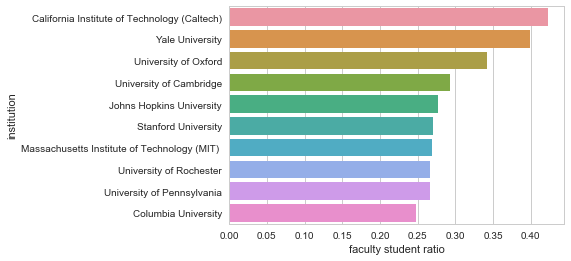

In [172]:
plot = sns.barplot("fac_stud_ratio", "institution", data=temp_df)
plot.set(xlabel="faculty student ratio", ylabel="institution")

#### (1-b) Best universities in term of ratio between international and total students

As in the previous case, we create a new column holding the ratio between "international_students" and "total_students" and then extract a subset with the features we need and sort according to the values just computed.

In [173]:
topuniversities['inter_student_ratio'] = topuniversities['international_students']/topuniversities['total_students']
temp_df = topuniversities[['institution', 'inter_student_ratio']].sort_values(ascending=False, by='inter_student_ratio').head(10)
temp_df

,institution,inter_student_ratio
34,London School of Economics and Political Scien...,0.691393
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570047
7,Imperial College London,0.543567
198,Maastricht University,0.502533
46,Carnegie Mellon University,0.478062
6,UCL (University College London),0.477928
91,University of St Andrews,0.457955
41,The University of Melbourne,0.427434
126,Queen Mary University of London,0.421816
25,The University of Hong Kong,0.407144


#### (1-b) [Plot] Best universities in term of ratio between international and total students

[<matplotlib.text.Text at 0x12078af60>, <matplotlib.text.Text at 0x120ced7b8>]

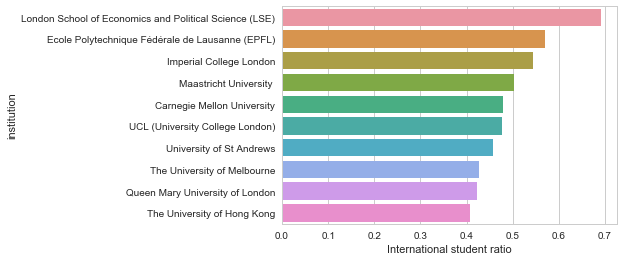

In [174]:
plot = sns.barplot("inter_student_ratio", "institution", data=temp_df)
plot.set(xlabel="International student ratio", ylabel="institution")

#### (1-c) Aggregation of the data in (a) by country.

We apply groupby on the attribute 'country' and then use mean() to compute the mean of faculty/students ratio for each country. We store the result in top_by_country, then sort on 'fac_stud_ratio' and store on topby_country

In [175]:
top_by_country = topuniversities.groupby('country', as_index=False)['fac_stud_ratio'].mean()
topby_country = top_by_country.sort_values(ascending=False, by='fac_stud_ratio').head(10)
topby_country

,country,fac_stud_ratio
23,Russia,0.221910
8,Denmark,0.186580
24,Saudi Arabia,0.175828
25,Singapore,0.162279
17,Japan,0.155840
18,Malaysia,0.153893
33,United States,0.151151
27,South Korea,0.149356
10,France,0.144006
15,Israel,0.136047


[<matplotlib.text.Text at 0x11960b780>, <matplotlib.text.Text at 0x11ab64630>]

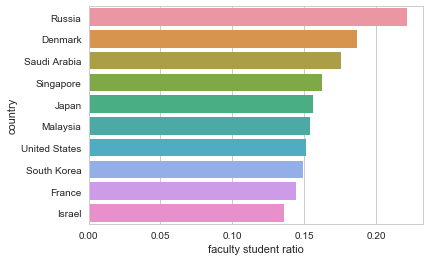

In [176]:
plot = sns.barplot("fac_stud_ratio", "country", data=topby_country)
plot.set(xlabel="faculty student ratio", ylabel="country")

<h4> (1-c) Aggregation of the data in (b) by country.

In [177]:
top_by_country = topuniversities.groupby('country', as_index=False)['inter_student_ratio'].mean()
top = top_by_country.sort_values(ascending=False, by='inter_student_ratio').head(10)
top

,country,inter_student_ratio
32,United Kingdom,0.351308
1,Australia,0.346878
30,Switzerland,0.313816
12,Hong Kong,0.312148
2,Austria,0.306095
25,Singapore,0.277091
5,Canada,0.252604
21,New Zealand,0.248971
20,Netherlands,0.245456
14,Ireland,0.241791


[<matplotlib.text.Text at 0x118ccda20>, <matplotlib.text.Text at 0x11b05f4a8>]

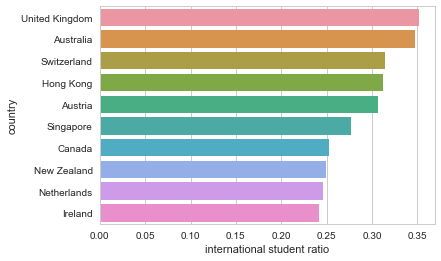

In [178]:
plot = sns.barplot("inter_student_ratio", "country", data=top)
plot.set(xlabel="international student ratio", ylabel="country")

<h4> (1-d) Aggregation of the data in (a) by region.

In [179]:
top_by_region = topuniversities.groupby('region', as_index=False)['fac_stud_ratio'].mean()
topby_region = top_by_region.sort_values(ascending=False, by='fac_stud_ratio').head(10)
topby_region

,region,fac_stud_ratio
4,North America,0.144831
1,Asia,0.131938
2,Europe,0.120003
3,Latin America,0.096779
0,Africa,0.088450
5,Oceania,0.075003


[<matplotlib.text.Text at 0x119ead7f0>, <matplotlib.text.Text at 0x118ce3160>]

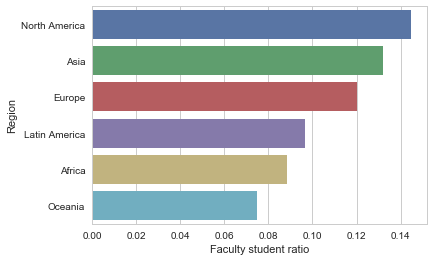

In [180]:
plot = sns.barplot("fac_stud_ratio", "region", data=topby_region)
plot.set(xlabel="Faculty student ratio", ylabel="Region")

<h4> (2-d) Aggregation of the data in (b) by region.

In [181]:
top_by_region = topuniversities.groupby('region', as_index=False)['inter_student_ratio'].mean()
by_region = top_by_region.sort_values(ascending=False, by='inter_student_ratio').head(10)

[<matplotlib.text.Text at 0x11fbe0e80>, <matplotlib.text.Text at 0x118cde3c8>]

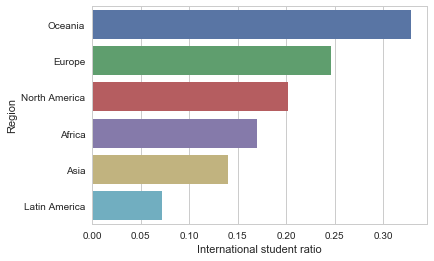

In [182]:
plot = sns.barplot("inter_student_ratio", "region", data=by_region)
plot.set(xlabel="International student ratio", ylabel="Region")

## Task 2. Top-ranking universities in www.timeshighereducation.com (ranking 2018)

##### Getting data
We apply the same approach as in point 1 to fetch and store the data in the timeshigher dataframe. <br>
Here we have to make a conversion from students per faculty to the ratio faculty/students.

In [183]:
# Make a reference how we got this url form postman interceptor!!
URL = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

r = requests.get(URL)
jsonFile = r.json()
jsonObj = json.dumps(jsonFile)
resp_dict = json.loads(jsonObj)
universities = resp_dict['data']

name = []
rank = []
country = []
tot_st = []
fac_stud_ratio = []
inter_student_ratio = []
i = 0
uni_limit = 200

for d in universities:
    name.append(d['name'])
    rank.append(d['rank'])
    country.append(d['location'])
    tot_st.append(int(d['stats_number_students'].replace(",", "")))
    fac_stud_ratio.append(float(d['stats_student_staff_ratio']))
    inter_student_ratio.append(int(d['stats_pc_intl_students'][:-1])) #remove the % character
    
    
    i += 1
    if i == uni_limit:
        break
        
timeshigher = pd.DataFrame()
timeshigher['institution'] = name
timeshigher['rank'] = rank
timeshigher['country'] = country
timeshigher['total_students'] =  tot_st
fac_stud_ratio[:] = [1 / x for x in fac_stud_ratio]  # from students per faculty ---> faculty per student
timeshigher['fac_stud_ratio'] =  fac_stud_ratio 
inter_student_ratio[:] = [x / 100 for x in inter_student_ratio]  # divide values by 100, e.x. 38% = 38/100
timeshigher['inter_student_ratio'] =  inter_student_ratio

timeshigher.head(5)

,institution,rank,country,total_students,fac_stud_ratio,inter_student_ratio
0,University of Oxford,1,United Kingdom,20409,0.089286,0.38
1,University of Cambridge,2,United Kingdom,18389,0.091743,0.35
2,California Institute of Technology,=3,United States,2209,0.153846,0.27
3,Stanford University,=3,United States,15845,0.133333,0.22
4,Massachusetts Institute of Technology,5,United States,11177,0.114943,0.34


We run a check for possible errors in the ordering according to rank that we have received from the json file, and we find that there's no error in the sequence.

In [184]:
rank_copy = timeshigher['rank'].copy(deep=True)
rank_copy = pd.Series(rank_copy).str.replace('=','')
rank_copy = pd.to_numeric(rank_copy)

test_str = ''
test_list = []
for i in range(rank_copy.size - 1):
    current =  rank_copy[i]
    next_num = rank_copy[i+1]  
    if next_num == (current):
        test_str = str(test_str) + str(current) + (', ')
        test_list.append(current)
    if next_num > (current + 1): 
        test_str = test_str + str(current) + ' --> ' + str(next_num)
        if next_num > (current + len(test_list) + 1):
            print('A problem observed in this ranking sequence: ', test_str)      
        test_str = ''
        test_list = []
#No output since there's no error

As suggested in the document, the case of ties are handled according to who comes first in the document, hence the ranking is translated into the position (starting from 0) +1.

In [185]:
new_rank = timeshigher['rank'].copy(deep=True)
for i in range(timeshigher['rank'].size):
    if '=' in timeshigher.iloc[i]['rank']:        
        new_rank[i] = i + 1
        
timeshigher['rank'] = new_rank

In [186]:
timeshigher.head(5)

,institution,rank,country,total_students,fac_stud_ratio,inter_student_ratio
0,University of Oxford,1,United Kingdom,20409,0.089286,0.38
1,University of Cambridge,2,United Kingdom,18389,0.091743,0.35
2,California Institute of Technology,3,United States,2209,0.153846,0.27
3,Stanford University,4,United States,15845,0.133333,0.22
4,Massachusetts Institute of Technology,5,United States,11177,0.114943,0.34


In [187]:
timeshigher.tail(5)

,institution,rank,country,total_students,fac_stud_ratio,inter_student_ratio
195,Paris-Sorbonne University – Paris 4,196,France,22042,0.033113,0.15
196,"Royal Holloway, University of London",197,United Kingdom,8931,0.064935,0.40
197,"University of California, Riverside",198,United States,20740,0.048309,0.14
198,University of Gothenburg,199,Sweden,18378,0.100000,0.13
199,National Taiwan University,200,Taiwan,31758,0.086957,0.08


#### (2-a) Best universities in term of ratio between faculty members and students

In [188]:
timeshigher_ratio = timeshigher[['institution', 'fac_stud_ratio']].sort_values(ascending=False, by='fac_stud_ratio').head(10)
timeshigher_ratio

,institution,fac_stud_ratio
105,Vanderbilt University,0.303030
109,University of Copenhagen,0.243902
153,University of Rochester,0.232558
11,Yale University,0.232558
12,Johns Hopkins University,0.232558
97,Emory University,0.227273
16,Duke University,0.222222
114,École Polytechnique,0.196078
183,Scuola Normale Superiore di Pisa,0.192308
101,University of Pittsburgh,0.169492


#### (2-a)[Plot] Best universities in term of ratio between faculty members and students

[<matplotlib.text.Text at 0x119e46048>, <matplotlib.text.Text at 0x11fa5fa58>]

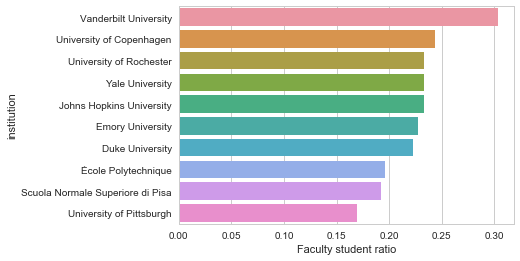

In [189]:
plot = sns.barplot("fac_stud_ratio", "institution", data=timeshigher_ratio)
plot.set(xlabel="Faculty student ratio", ylabel="institution")

#### (2-b) Best universities in term of ratio of international students 

In [190]:
timeshigher_inter = timeshigher[['institution', 'inter_student_ratio']].sort_values(ascending=False, by='inter_student_ratio').head(10)
timeshigher_inter

,institution,inter_student_ratio
24,London School of Economics and Political Science,0.71
178,University of Luxembourg,0.57
37,École Polytechnique Fédérale de Lausanne,0.55
7,Imperial College London,0.55
102,Maastricht University,0.50
15,University College London,0.49
143,University of St Andrews,0.48
23,Carnegie Mellon University,0.45
120,Queen Mary University of London,0.45
39,University of Hong Kong,0.42


#### (2-b)[Plot] Best universities in term of ratio of international students 

[<matplotlib.text.Text at 0x11a0dc400>, <matplotlib.text.Text at 0x119ea80f0>]

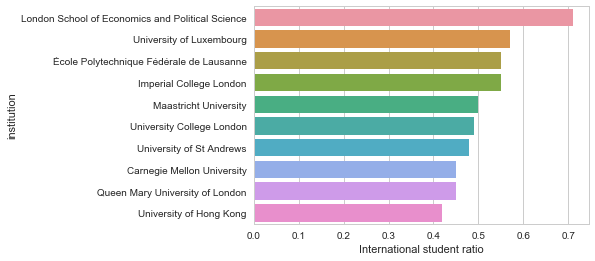

In [191]:
plot = sns.barplot("inter_student_ratio", "institution", data=timeshigher_inter)
plot.set(xlabel="International student ratio", ylabel="institution")

#### (2-c) Aggregation of the data in (a-faculty/students ration) by country.

In [192]:
times_by_country = timeshigher.groupby('country', as_index=False)['fac_stud_ratio'].mean()
times_country = times_by_country.sort_values(ascending=False, by='fac_stud_ratio').head(10)
times_country

,country,fac_stud_ratio
5,Denmark,0.160166
11,Italy,0.138889
17,Russian Federation,0.136986
12,Japan,0.132098
26,United States,0.106390
7,France,0.099352
4,China,0.087420
24,Taiwan,0.086957
19,South Africa,0.085470
23,Switzerland,0.083447


#### (2-c) [Plot] Aggregation of the data in (a-faculty/students ration) by country.

[<matplotlib.text.Text at 0x120475e10>, <matplotlib.text.Text at 0x120f4e898>]

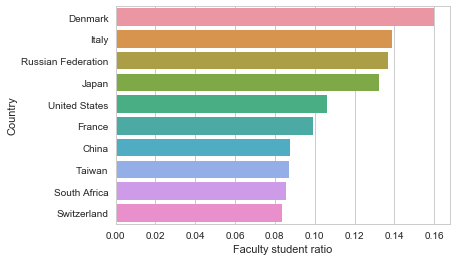

In [193]:
plot = sns.barplot("fac_stud_ratio", "country", data=times_country)
plot.set(xlabel="Faculty student ratio", ylabel="Country")

#### (2-c) Aggregation of the data in (b-international students/total students ratio) by country.

In [194]:
times_by_country = timeshigher.groupby('country', as_index=False)['inter_student_ratio'].mean()
times_country = times_by_country.sort_values(ascending=False, by='inter_student_ratio').head(10)
times_country 

,country,inter_student_ratio
13,Luxembourg,0.570000
25,United Kingdom,0.365484
9,Hong Kong,0.328000
23,Switzerland,0.314286
0,Australia,0.307500
18,Singapore,0.305000
15,New Zealand,0.290000
10,Ireland,0.270000
1,Austria,0.260000
3,Canada,0.225000


#### (2-c) [Plot] Aggregation of the data in (b-international students/total students ratio) by country.

[<matplotlib.text.Text at 0x1212a1f28>, <matplotlib.text.Text at 0x1212804a8>]

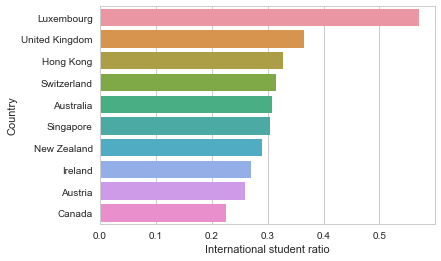

In [195]:
plot = sns.barplot("inter_student_ratio", "country", data=times_country)
plot.set(xlabel="International student ratio", ylabel="Country")

Since the Region information is missing for the timeshigher dataframe, we use topuniversities to derive a dictionary having country->region. We realize the method works and the only entries which didn't get a match are n.192 and n.177.
These universities' region is Europe, having Nan value we just use fillna().

In [196]:
country_region = dict(zip(topuniversities.country.values,topuniversities.region.values))
timeshigher['region'] = timeshigher['country'].map(country_region)

timeshigher.region.fillna(value = "Europe")
timeshigher.head(10)
topuniversities.head(10)

,institution,rank,country,region,international_faculty,total_faculty,international_students,total_students,fac_stud_ratio,inter_student_ratio
0,Massachusetts Institute of Technology (MIT),1,United States,North America,1679,2982,3717,11067,0.269450,0.335863
1,Stanford University,2,United States,North America,2042,4285,3611,15878,0.269870,0.227422
2,Harvard University,3,United States,North America,1311,4350,5266,22429,0.193945,0.234785
3,California Institute of Technology (Caltech),4,United States,North America,350,953,647,2255,0.422616,0.286918
4,University of Cambridge,5,United Kingdom,Europe,2278,5490,6699,18770,0.292488,0.356899
5,University of Oxford,6,United Kingdom,Europe,2964,6750,7353,19720,0.342292,0.372870
6,UCL (University College London),7,United Kingdom,Europe,2554,6345,14854,31080,0.204151,0.477928
7,Imperial College London,8,United Kingdom,Europe,2071,3930,8746,16090,0.244251,0.543567
8,University of Chicago,9,United States,North America,635,2449,3379,13557,0.180645,0.249244
9,ETH Zurich - Swiss Federal Institute of Techno...,10,Switzerland,Europe,1886,2477,7563,19815,0.125006,0.381681


#### 2-d) Aggregation of the data in (a-faculty/students ration) by region.

In [197]:
times_by_region = timeshigher.groupby('region', as_index=False)['fac_stud_ratio'].mean()
region  = times_by_region.sort_values(ascending=False, by='fac_stud_ratio').head(10)
region

,region,fac_stud_ratio
3,North America,0.101655
0,Africa,0.085470
1,Asia,0.080345
2,Europe,0.065209
4,Oceania,0.039895


#### 2-d) Aggregation of the data in (a-faculty/students ration) by region.

[<matplotlib.text.Text at 0x12105e940>, <matplotlib.text.Text at 0x120962f98>]

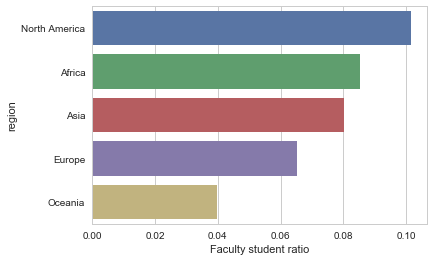

In [198]:
plot = sns.barplot("fac_stud_ratio", "region", data=region)
plot.set(xlabel="Faculty student ratio", ylabel="region")

##### (2-d) Aggregation of the data in (b-international students/total students ratio) by region.

In [199]:
times_by_region = timeshigher.groupby('region', as_index=False)['inter_student_ratio'].mean()
timesby_region = times_by_region.sort_values(ascending=False, by='inter_student_ratio').head(10)
timesby_region

,region,inter_student_ratio
4,Oceania,0.305556
2,Europe,0.241616
3,North America,0.185588
0,Africa,0.180000
1,Asia,0.165238


[<matplotlib.text.Text at 0x1212a1d68>, <matplotlib.text.Text at 0x12103b550>]

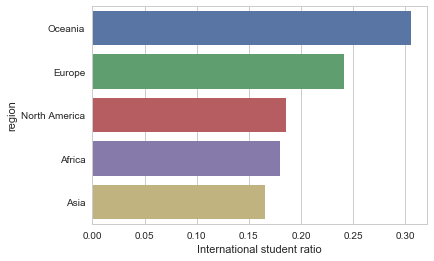

In [200]:
plot = sns.barplot("inter_student_ratio", "region", data=timesby_region)
plot.set(xlabel="International student ratio", ylabel="region")

## Task 3. Merger of the DataFrames

We have noticed that the same univeristy can be refered with a slightly different name in the ranking lists. For example:<br>
topuniveristies -> Ecole Polytechnique Fédérale de Lausanne (EPFL)<br>
timeshighereducation -> École Polytechnique Fédérale de Lausanne<br>

To solve this problem we relied on a sudden intuition related to doing searches on the web, i.e. we remembered that while searching for anything on the english version of wikipedia, the result will always have the same name no matter whether we input the english name, a different variation of it or the name of the institution in its country's language. <br>
We looked for a way to exploit this property and found out that there's a wikipedia python library available which allows us to solve the merge problem. 

In [201]:
import wikipedia as wk
wk.set_lang("en")

We set the unique institution name according to the wikipedia database (we change the current name with the one reported on wikipedia).

In [202]:
for i in range(0, 199):
    name = topuniversities.loc[i,'institution']
    res = wk.search(name)
    topuniversities.loc[i,'institution'] = res[0]

topuniversities.head()

,institution,rank,country,region,international_faculty,total_faculty,international_students,total_students,fac_stud_ratio,inter_student_ratio
0,Massachusetts Institute of Technology,1,United States,North America,1679,2982,3717,11067,0.269450,0.335863
1,Stanford University,2,United States,North America,2042,4285,3611,15878,0.269870,0.227422
2,Harvard University,3,United States,North America,1311,4350,5266,22429,0.193945,0.234785
3,California Institute of Technology,4,United States,North America,350,953,647,2255,0.422616,0.286918
4,University of Cambridge,5,United Kingdom,Europe,2278,5490,6699,18770,0.292488,0.356899


The same operation is performed for timeshigher

In [203]:
for x in range(0, 199):
    name = timeshigher.loc[x,'institution']
    res = wk.search(name)
    timeshigher.loc[x,'institution'] = res[0]
    
timeshigher.head()

,institution,rank,country,total_students,fac_stud_ratio,inter_student_ratio,region
0,University of Oxford,1,United Kingdom,20409,0.089286,0.38,Europe
1,University of Cambridge,2,United Kingdom,18389,0.091743,0.35,Europe
2,California Institute of Technology,3,United States,2209,0.153846,0.27,North America
3,Stanford University,4,United States,15845,0.133333,0.22,North America
4,Massachusetts Institute of Technology,5,United States,11177,0.114943,0.34,North America


We perform the merge operation on the two dataframes using "institution".

In [204]:
full_rank = pd.merge(topuniversities, timeshigher, how='inner', on='institution', sort=True)
full_rank['rank_x'] = pd.to_numeric(full_rank['rank_x'])
full_rank['rank_y'] = pd.to_numeric(full_rank['rank_y'])
full_rank = full_rank.sort_values(by='rank_x', ascending=True)
full_rank.head()


,institution,rank_x,country_x,region_x,international_faculty,total_faculty,international_students,total_students_x,fac_stud_ratio_x,inter_student_ratio_x,rank_y,country_y,total_students_y,fac_stud_ratio_y,inter_student_ratio_y,region_y
41,Massachusetts Institute of Technology,1,United States,North America,1679,2982,3717,11067,0.269450,0.335863,5,United States,11177,0.114943,0.34,North America
68,Stanford University,2,United States,North America,2042,4285,3611,15878,0.269870,0.227422,4,United States,15845,0.133333,0.22,North America
25,Harvard University,3,United States,North America,1311,4350,5266,22429,0.193945,0.234785,6,United States,20326,0.112360,0.26,North America
6,California Institute of Technology,4,United States,North America,350,953,647,2255,0.422616,0.286918,3,United States,2209,0.153846,0.27,North America
93,University of Cambridge,5,United Kingdom,Europe,2278,5490,6699,18770,0.292488,0.356899,2,United Kingdom,18389,0.091743,0.35,Europe


A selection and ordering of features is made in order to immediately get an idea of how data compare between the topuniversities ranking (x) and the timeshighereducation one (y)

In [205]:
comparable_df =full_rank[['institution','rank_x','rank_y', 'total_students_x','total_students_y','fac_stud_ratio_x','fac_stud_ratio_y','inter_student_ratio_x','inter_student_ratio_y','country_x','region_x']]
comparable_df

,institution,rank_x,rank_y,total_students_x,total_students_y,fac_stud_ratio_x,fac_stud_ratio_y,inter_student_ratio_x,inter_student_ratio_y,country_x,region_x
41,Massachusetts Institute of Technology,1,5,11067,11177,0.269450,0.114943,0.335863,0.34,United States,North America
68,Stanford University,2,4,15878,15845,0.269870,0.133333,0.227422,0.22,United States,North America
25,Harvard University,3,6,22429,20326,0.193945,0.112360,0.234785,0.26,United States,North America
6,California Institute of Technology,4,3,2255,2209,0.422616,0.153846,0.286918,0.27,United States,North America
93,University of Cambridge,5,2,18770,18389,0.292488,0.091743,0.356899,0.35,United Kingdom,Europe
121,University of Oxford,6,1,19720,20409,0.342292,0.089286,0.372870,0.38,United Kingdom,Europe
77,University College London,7,16,31080,30304,0.204151,0.095238,0.477928,0.49,United Kingdom,Europe
30,Imperial College London,8,8,16090,15857,0.244251,0.087719,0.543567,0.55,United Kingdom,Europe
95,University of Chicago,9,9,13557,13525,0.180645,0.161290,0.249244,0.25,United States,North America
17,ETH Zurich,10,10,19815,19233,0.125006,0.068493,0.381681,0.38,Switzerland,Europe


## Task 4. Exploratory analysis

#### First observation: incongruence between faculty to students ratios
At first glance we notice a stark difference between the percentages reported by with respect to faculty/student ration. 

For the following observations and calculations we used the method corr() which computes pairwise correlation of the columns in our DataFrame. The correlation we got for the rankings where not as high as we expected them to be<br>
Furthermore, for every correlation that we found we plotted scatterplots which show the different degrees of correlation between the input columns.<br>
When the slope of the line in the plot is negative, the correlation is negative; and vice versa.<br>

In [206]:
full_rank['rank_x'] = pd.to_numeric(full_rank['rank_x'])
full_rank['rank_y'] = pd.to_numeric(full_rank['rank_y'])
full_rank['rank_x'].corr(full_rank['rank_y'])

0.68798003165293664

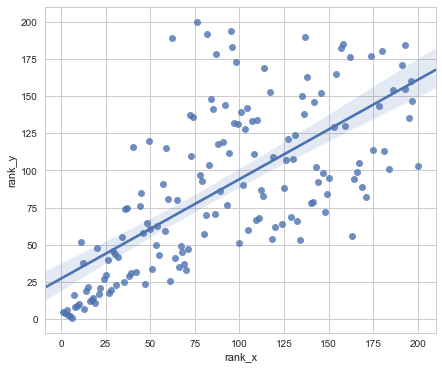

In [207]:
sns.set_style("whitegrid")
plt.subplots(figsize=(7, 6))
ax = sns.regplot(x=full_rank['rank_x'], y=full_rank['rank_y'], data=topuniversities)

By observing the data, we noticed that there is a trend in univeristies with high number of international students to have respectively high numbers of international faculty members. This is presented in the following computation and plot:

In [208]:
full_rank['international_faculty'].corr(full_rank['international_students'])

0.57523891752198286

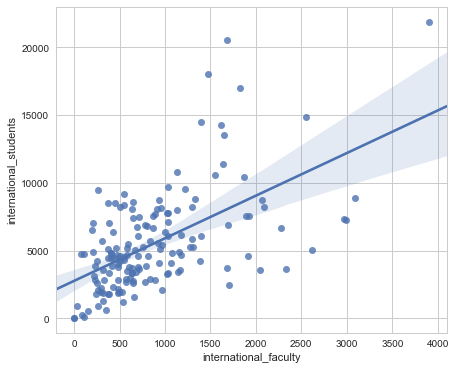

In [209]:
sns.set_style("whitegrid")
plt.subplots(figsize=(7, 6))
ax = sns.regplot(x=full_rank['international_faculty'], y=full_rank['international_students'], data=topuniversities)

One quite interesting correlation that we observed is that the Asian univeristies with a big number of international faculty members, have a also a good position in the ranking of topuniversities website. More specifically, it is a negative correlation since the smallest the value of the rank the better the position.

In [210]:
full_rank.loc[full_rank['region_x'] == 'Asia']['rank_x'].corr(
    full_rank.loc[full_rank['region_x'] == 'Asia']['international_faculty'])

-0.45689087585769583

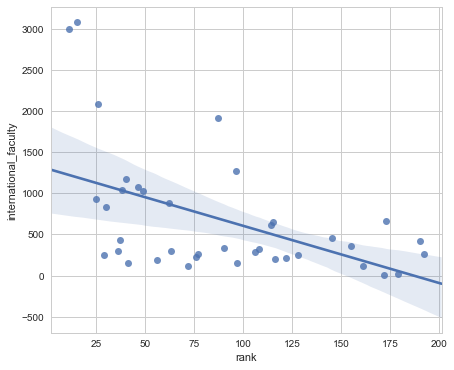

In [211]:
plt.subplots(figsize=(7, 6))
ax = sns.regplot(x=topuniversities.loc[topuniversities['region'] == 'Asia']['rank'], 
    y=topuniversities.loc[topuniversities['region'] == 'Asia']['international_faculty'], data=topuniversities)

## Task 5. Finding the best univeristy

The first approach to find the best university is to give equal weight to both ranking and computing the average position between the two. 

In [212]:
full_rank['final_rank'] = full_rank[['rank_x', 'rank_y']].mean(axis=1)
cols = full_rank.columns.tolist()
cols = cols[:1] + cols[-1:] + cols[1:-1]
full_rank = full_rank[cols]

full_rank = full_rank.sort_values(by='final_rank', ascending=True)
full_rank.head(10)

,institution,final_rank,rank_x,country_x,region_x,international_faculty,total_faculty,international_students,total_students_x,fac_stud_ratio_x,inter_student_ratio_x,rank_y,country_y,total_students_y,fac_stud_ratio_y,inter_student_ratio_y,region_y
41,Massachusetts Institute of Technology,3.0,1,United States,North America,1679,2982,3717,11067,0.269450,0.335863,5,United States,11177,0.114943,0.34,North America
68,Stanford University,3.0,2,United States,North America,2042,4285,3611,15878,0.269870,0.227422,4,United States,15845,0.133333,0.22,North America
6,California Institute of Technology,3.5,4,United States,North America,350,953,647,2255,0.422616,0.286918,3,United States,2209,0.153846,0.27,North America
93,University of Cambridge,3.5,5,United Kingdom,Europe,2278,5490,6699,18770,0.292488,0.356899,2,United Kingdom,18389,0.091743,0.35,Europe
121,University of Oxford,3.5,6,United Kingdom,Europe,2964,6750,7353,19720,0.342292,0.372870,1,United Kingdom,20409,0.089286,0.38,Europe
25,Harvard University,4.5,3,United States,North America,1311,4350,5266,22429,0.193945,0.234785,6,United States,20326,0.112360,0.26,North America
30,Imperial College London,8.0,8,United Kingdom,Europe,2071,3930,8746,16090,0.244251,0.543567,8,United Kingdom,15857,0.087719,0.55,Europe
95,University of Chicago,9.0,9,United States,North America,635,2449,3379,13557,0.180645,0.249244,9,United States,13525,0.161290,0.25,North America
17,ETH Zurich,10.0,10,Switzerland,Europe,1886,2477,7563,19815,0.125006,0.381681,10,Switzerland,19233,0.068493,0.38,Europe
58,Princeton University,10.0,13,United States,North America,246,1007,1793,8069,0.124799,0.222208,7,United States,7955,0.120482,0.24,North America


In [213]:
print('Giving equal weight to both rankings, the best university is {0} with mean rank {1}'.format(
    full_rank.iloc[0]['institution'], full_rank.iloc[0]['final_rank']))


Giving equal weight to both rankings, the best university is Massachusetts Institute of Technology with mean rank 3.0
